In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
import missingno as msno

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
from warnings import filterwarnings
filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/mehranzeynalli/opt/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Data Contents -

This dataset contains four years of electrical consumption, generation, pricing, and weather data for Spain. Consumption and generation data was retrieved from ENTSOE a public portal for Transmission Service Operator (TSO) data. Settlement prices were obtained from the Spanish TSO Red Electric España. 

## Column Meanings - 

* Time: Datetime index localized to CET
* Generation biomass: biomass generation in MW
* Generation fossil brown coal/lignite: coal/lignite generation in MW
* Generation fossil coal-derived gas: coal gas generation in MW
* Generation fossil gas: gas generation in MW
* Generation fossil hard coal: coal generation in MW
* Generation fossil oil: oil generation in MW
* Generation fossil oil shale: shale oil generation in MW
* Generation fossil peat: peat generation in MW
* Generation geothermal: geothermal generation in MW
* Generation hydro pumped storage aggregated: hydro1 generation in MW
* Generation hydro pumped storage consumption: hydro2 generation in MW
* Generation hydro run-of-river and poundage: hydro3 generation in MW
* Generation hydro water reservoir: hydro4 generation in MW
* Generation marine: sea generation in MW
* Generation nuclear: nuclear generation in MW
* Generation other: other generation in MW
* Generation other renewable: other renewable generation in MW
* Generation solar: solar generation in MW
* Generation waste: waste generation in MW
* Generation wind offshore: wind offshore generation in MW
* Generation wind onshore: wind onshore generation in MW
* Gorecast solar day ahead: forecasted solar generation
* Gorecast wind offshore eday ahead: forecasted offshore wind generation
* Gorecast wind onshore day ahead: forecasted onshore wind generation
* Total load forecast: forecasted electrical demand
* Total load actual: actual electrical demand
* Price day ahead: forecasted price EUR/MWh
* Price actual: price in EUR/MWh

In [77]:
# Data
df_weather = pd.read_csv('Data/weather_features.csv',parse_dates=['dt_iso'])
df_energy = pd.read_csv('Data/energy_dataset.csv', parse_dates=['time'])

# Energy

In [78]:
#istifadesiz columlari drop edirik. Column 0 ve ya nan datadan ibaret oldugu ucun
df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)

In [79]:
df_energy['time'] = pd.to_datetime(df_energy['time'], utc=True, infer_datetime_format=True)
df_energy = df_energy.set_index('time')
df_energy.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04


In [29]:
df_energy.isnull().sum() # nan datalarin sayi

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [30]:
df_energy.duplicated().sum() #dublikatlar

0

<AxesSubplot:>

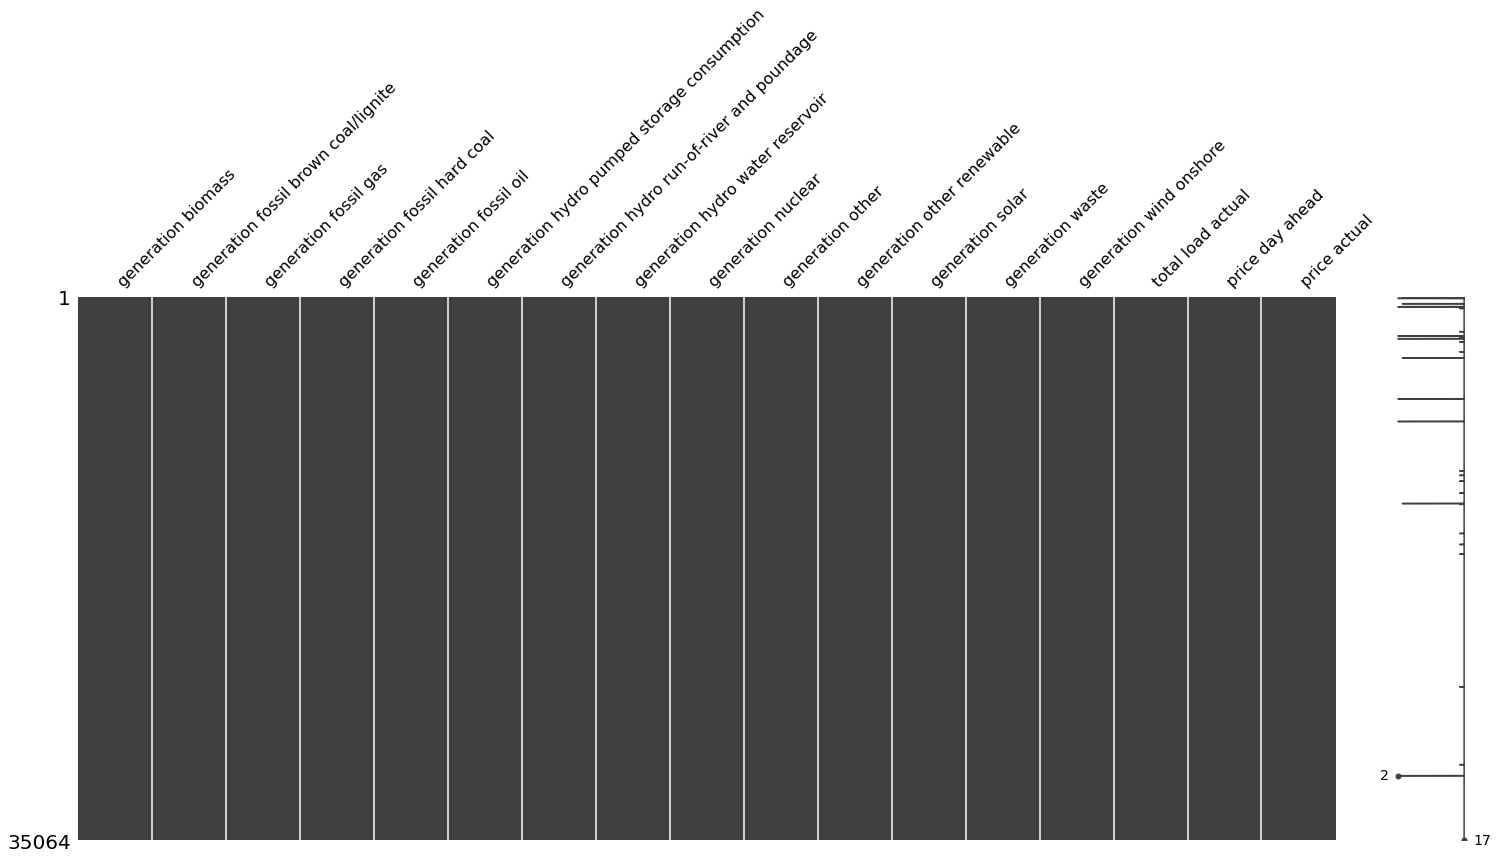

In [31]:
msno.matrix(df_energy)

In [5]:
df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

<AxesSubplot:>

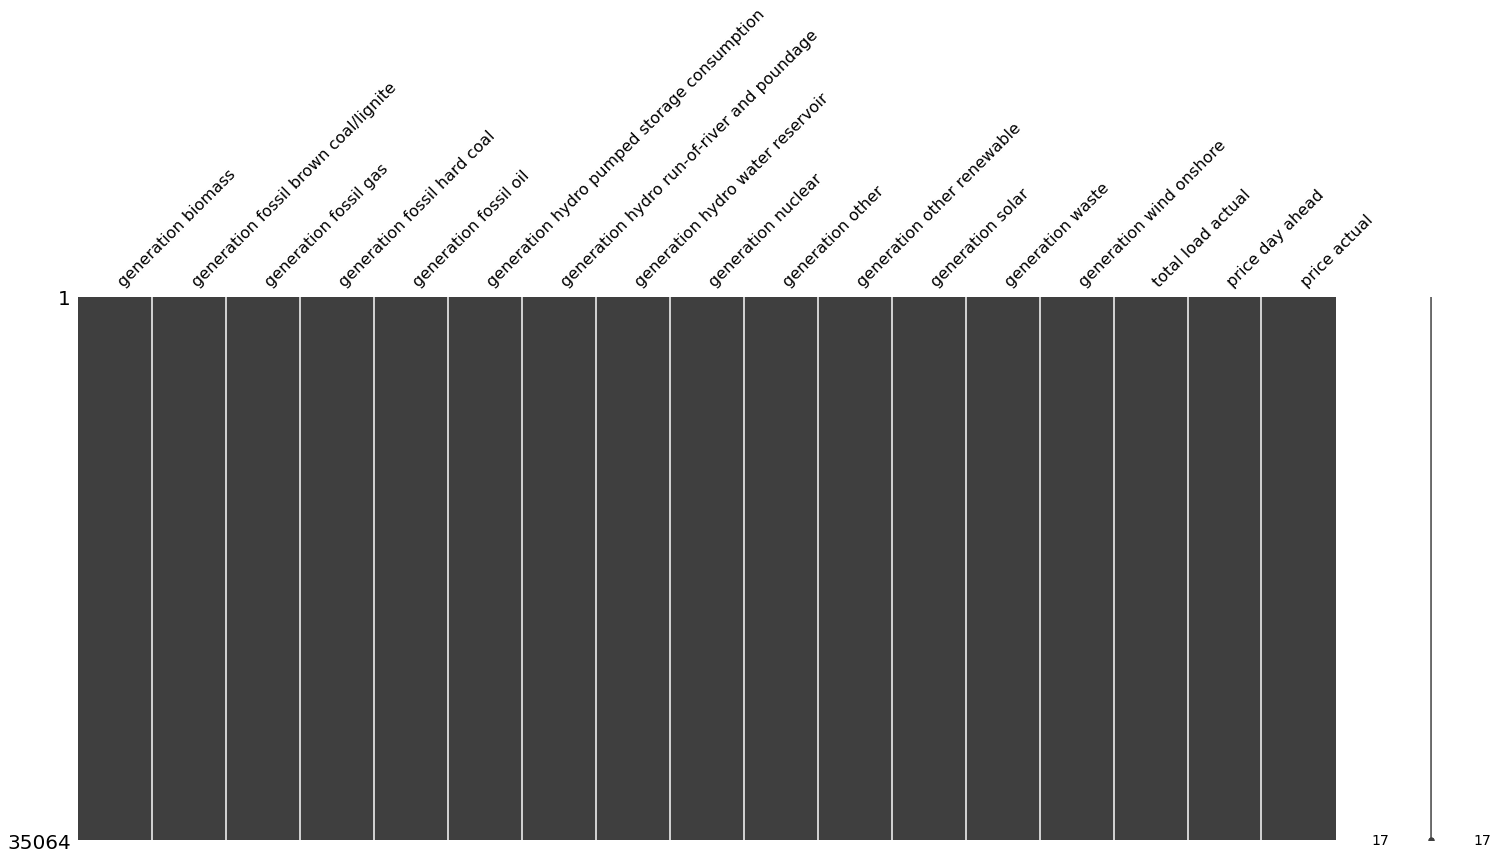

In [33]:
msno.matrix(df_energy)

In [6]:
df_energy.astype(bool).sum(axis=0) #0 larin sayi

generation biomass                             35060
generation fossil brown coal/lignite           24540
generation fossil coal-derived gas                 0
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation fossil oil shale                        0
generation fossil peat                             0
generation geothermal                              0
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption    22450
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation marine                                  0
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                              

# Weather Data

In [35]:
df_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [8]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df
df_weather = df_convert_dtypes(df_weather, np.int64, np.float64)

In [9]:
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [38]:
df_weather.head(3)

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
time,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,0.0,800.0,clear,sky is clear,01n


In [10]:
mean_weather_by_city = df_weather.groupby('city_name').mean()
mean_weather_by_city

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.848248,288.594704,291.021987,1284.010486,73.994221,2.786588,187.188043,0.117079,0.000327,0.000000,23.229648,760.917465
Bilbao,286.378489,284.916661,288.036687,1017.567439,79.089455,1.957470,159.883536,0.123493,0.001034,0.023455,43.960697,723.943228
Madrid,288.061071,286.824877,289.155600,1011.838448,59.776932,2.441696,173.293159,0.055083,0.000129,0.000029,22.397028,762.260264
Seville,293.105431,291.184103,295.962431,1018.504711,64.140732,2.483787,151.757179,0.045392,0.000180,0.000000,14.748770,771.409849
Valencia,290.780780,290.222277,291.355025,1015.973794,65.145113,2.692815,160.753820,0.035924,0.000226,0.000154,20.820999,781.228283


In [11]:
df_weather.isnull().sum() 

city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [12]:
df_weather.duplicated().sum()

8622

In [13]:
print('Umumilikde df_weather datasinda {} row var .'.format(df_energy.shape[0]))

cities = df_weather['city_name'].unique()
grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('{} row in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

Umumilikde df_weather datasinda 35064 row var .
35145 row in df_weather about city: Valencia.
36267 row in df_weather about city: Madrid.
35951 row in df_weather about city: Bilbao.
35476 row in df_weather about city:  Barcelona.
35557 row in df_weather about city: Seville.


In [14]:
df_weather_2 = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],keep='last').set_index('time')

df_weather = df_weather.reset_index().drop_duplicates(subset=['time', 'city_name'],keep='first').set_index('time')

In [15]:


print('There are {} observations in df_energy.'.format(df_energy.shape[0]))

grouped_weather = df_weather.groupby('city_name')

for city in cities:
    print('{} row in df_weather'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

There are 35064 observations in df_energy.
35064 row in df_weather about city: Valencia.
35064 row in df_weather about city: Madrid.
35064 row in df_weather about city: Bilbao.
35064 row in df_weather about city:  Barcelona.
35064 row in df_weather about city: Seville.


## unique

In [16]:
weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [17]:
weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [18]:
weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

In [19]:
# Define a function which will calculate R-squared score for the same column in two dataframes

def encode_and_display_r2_score(df_1, df_2, column, categorical=False):
    dfs = [df_1, df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print("R-Squared score of {} is {}".format(column, r2.round(3)))
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R-Squared score of weather_description is 0.973
R-Squared score of weather_main is 0.963
R-Squared score of weather_id is 0.921


In [20]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id', 
                              'weather_description', 'weather_icon'], axis=1)

# Visual

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
        <AxesSubplot:ylabel='Density'>]], dtype=object)

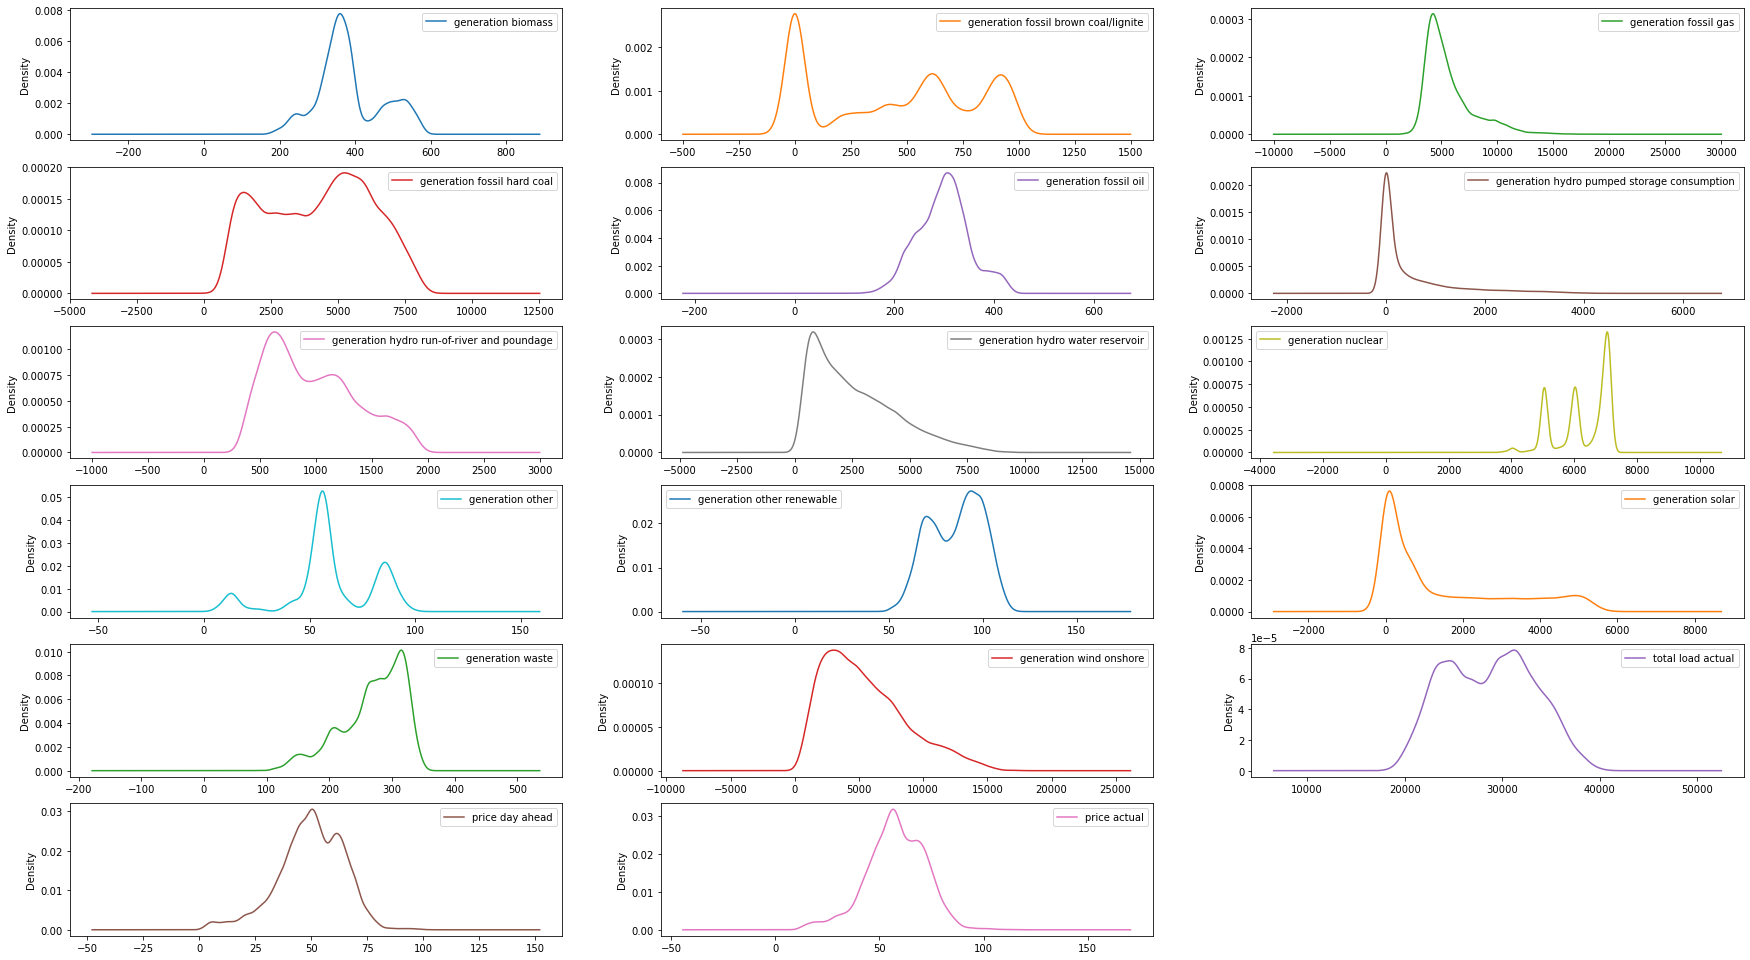

In [80]:
df_energy.plot(kind='density', subplots=True, layout=(7,3), figsize=(30,20), sharex=False)

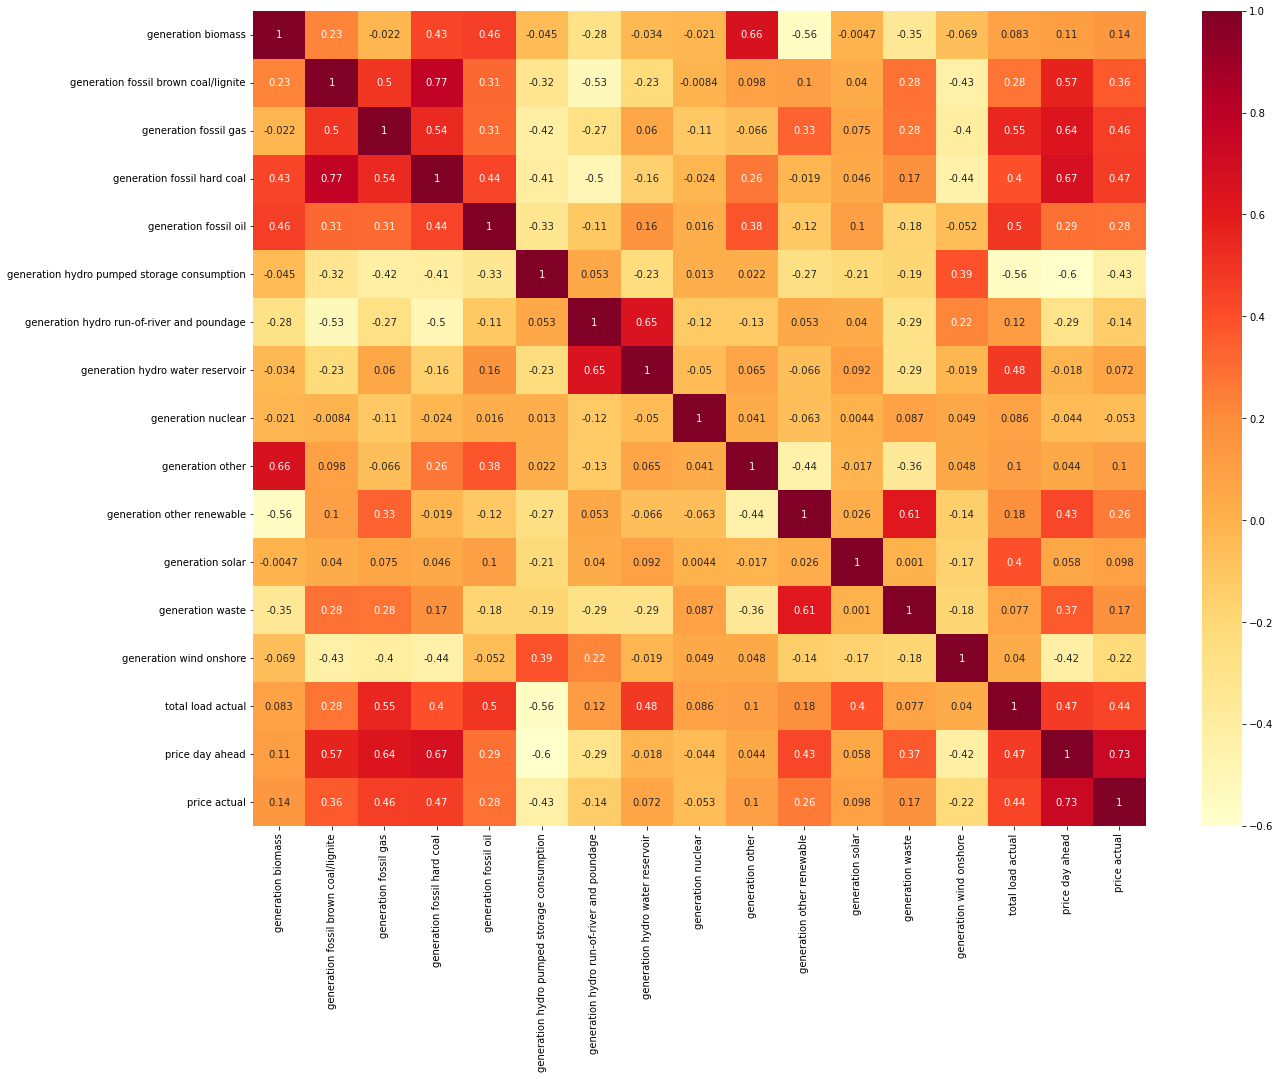

In [82]:
plt.figure(figsize=(20,15))
sns.heatmap(df_energy.corr(),annot=True,cmap='YlOrRd')
plt.show()

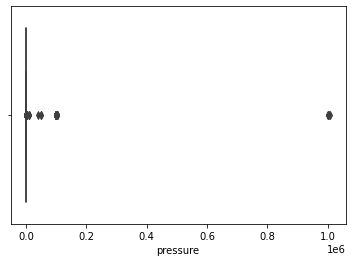

In [22]:
sns.boxplot(x=df_weather['pressure'])
plt.show()

In [50]:
df_weather.loc[df_weather.pressure > 1051, 'pressure'] = np.nan
df_weather.loc[df_weather.pressure < 931, 'pressure'] = np.nan

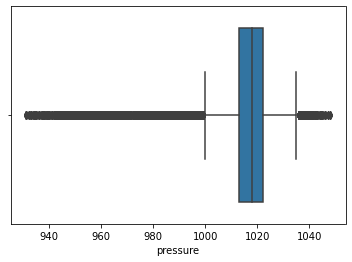

In [50]:
sns.boxplot(x=df_weather['pressure'])
plt.show()

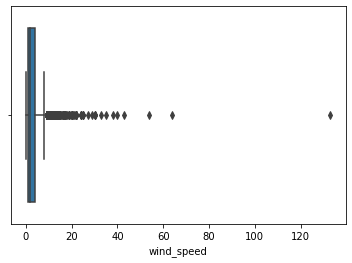

In [51]:
sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [51]:
df_weather.loc[df_weather.wind_speed > 50, 'wind_speed'] = np.nan

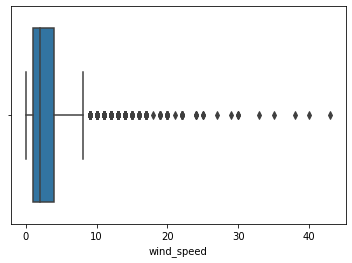

In [53]:
sns.boxplot(x=df_weather['wind_speed'])
plt.show()

In [162]:
df_weather.isna().sum()

city_name       0
temp            0
temp_min        0
temp_max        0
pressure      441
humidity        0
wind_speed      3
wind_deg        0
rain_1h         0
rain_3h         0
snow_3h         0
clouds_all      0
dtype: int64

In [52]:
df_weather.interpolate(method='linear', 
                       limit_direction='forward', 
                       inplace=True, axis=0)

In [25]:
# we found the wind speed is reported at 10 m:
# https://openweathermap.org/api/weather-map-2
#wind speed to the hub height of 110 m

df_weather['wind_speed_110'] = df_weather['wind_speed'] * (110/10) ** 0.2

In [26]:
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [27]:
df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)
    
df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore', 'total load actual', 'price day ahead', 'price actual', 'temp_Barcelona', 'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona', 'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona', 'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona', 'clouds_all_Barcelona', 'wind_speed_110_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao', 'rain_3h_Bilbao', 'snow_3h_Bilbao', 'clouds_all_Bilbao', 'wind_speed_110_Bilbao', 'temp_Madrid',
       'temp_

# Vizual ve Time Series Analiz

In [21]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

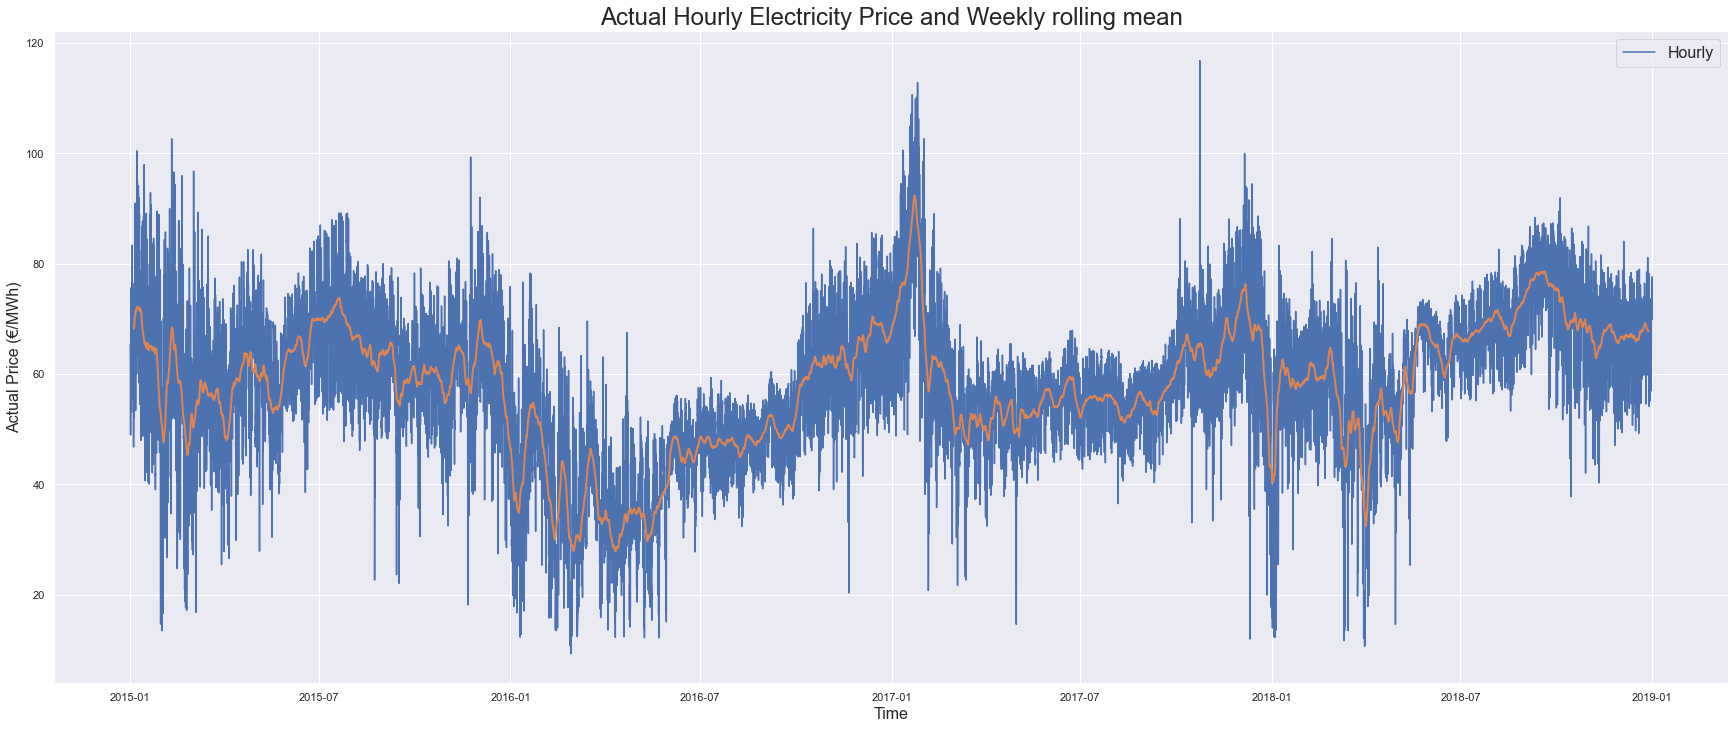

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

In [30]:
rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

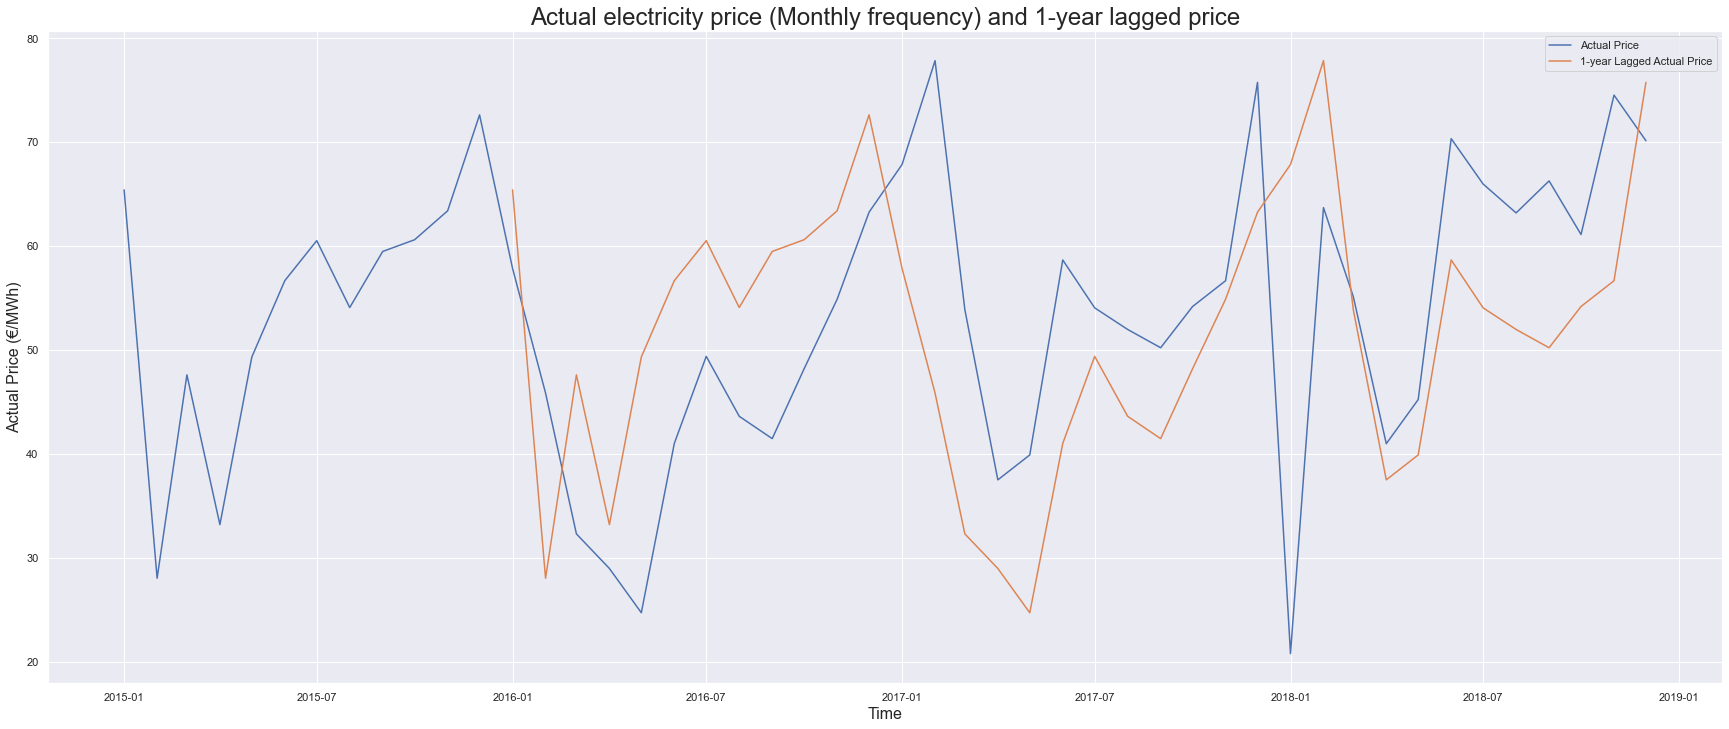

In [66]:
monthly_price = df_final['price actual'].asfreq('M')
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_final['price actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()

The figure above shows the (resampled) monthly frequency of the actual electricity price, along with its 1-year lagged monthly frequency. From this, we can see that there are indeed **seasonal patterns at the monthly scale**, as certain "spikes" in the time-series take place in exactly the same months. This means that it would be a good idea to create a new feature for the months. If the figure displayed the 1-year lagged actual energy price at hourly or weekly time scales, we would -of course- see no such seasonal patterns.

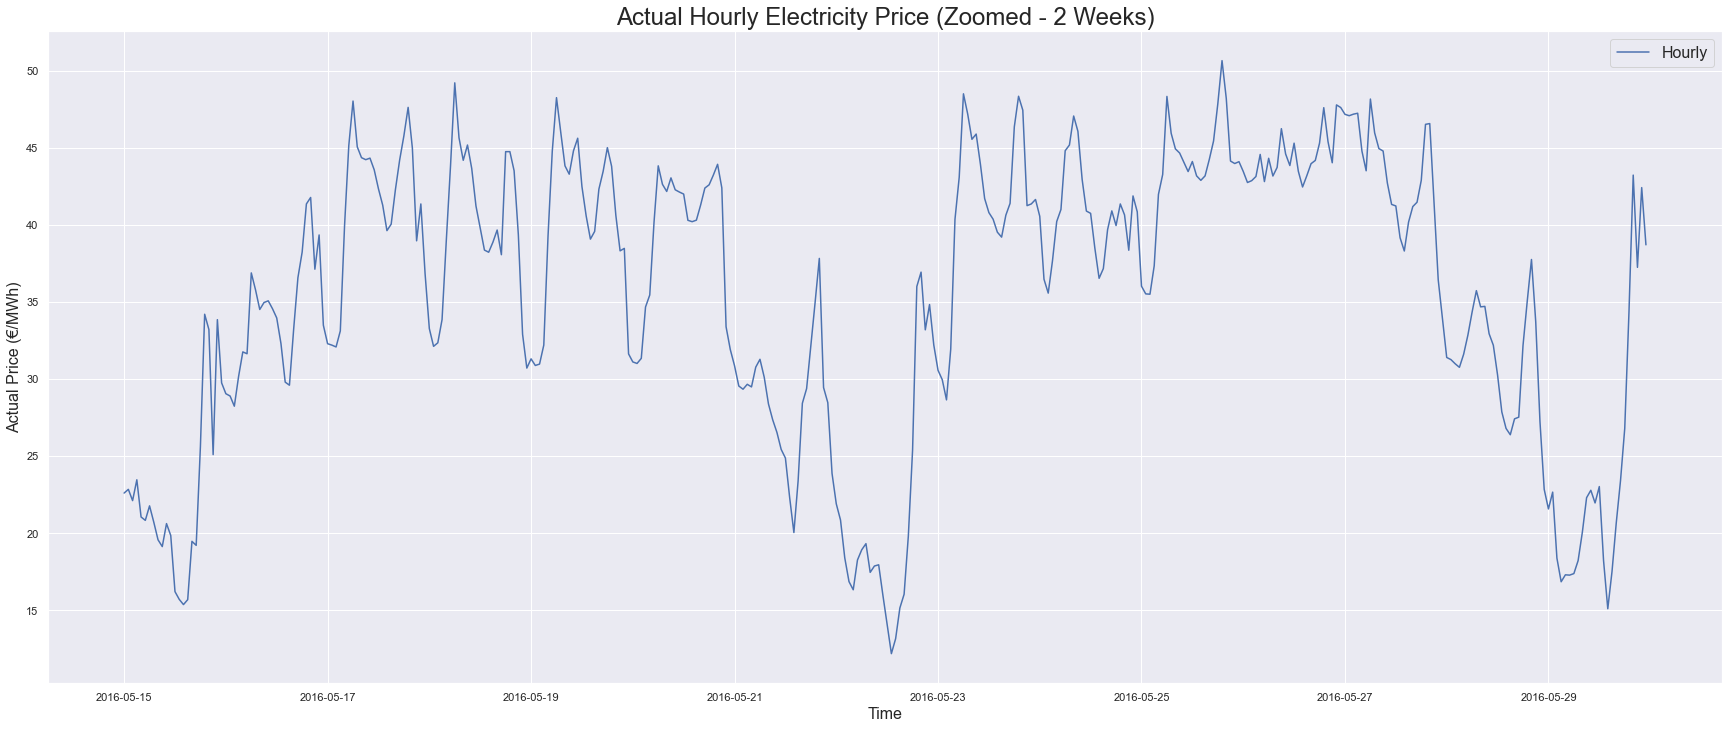

In [68]:
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)') #bunu azn e cevirmeli
plt.show()

- Həftədən həftəyə dövrilik, çünki elektrik enerjisinin qiyməti iş günlərində daha yüksək, həftə sonları və xüsusilə bazar günləri daha aşağı olur.

Text(0.5, 0, 'Price')

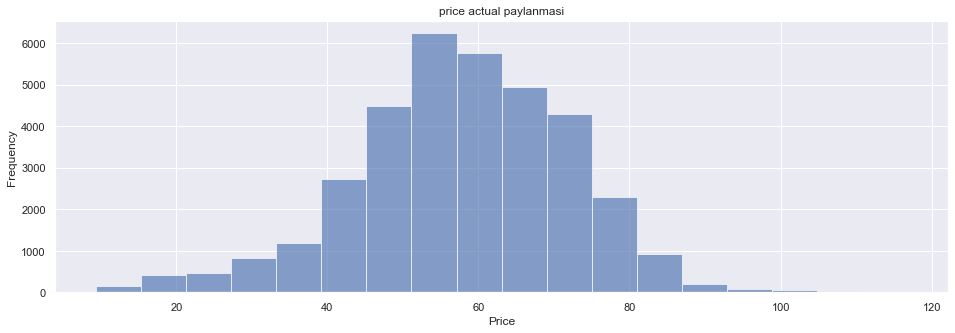

In [58]:
plt.figure(figsize=(16,5))
df_energy['price actual'].plot.hist(bins=18, alpha=0.65)
plt.title('price actual paylanmasi')
plt.xlabel('Price')

# Feature Engineering

In [59]:
df_final['hour'],df_final['weekday'],df_final['month']=df_final.index.hour,df_final.index.weekday,df_final.index.month

In [60]:
"""
2 - business saati
1 - Gunorta (siesta)
0 - diger vaxtlar
"""
for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business saati'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business saati'] = 1
    else:
        df_final.loc[position, 'business saati'] = 0

In [61]:
"""
2 - Bazar
1 - Senbe
0 - hefte ici
"""
for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

In [62]:
df_final['generation coal all'] = df_final['generation fossil hard coal'] + \
                                  df_final['generation fossil brown coal/lignite']

# Model XGBoost

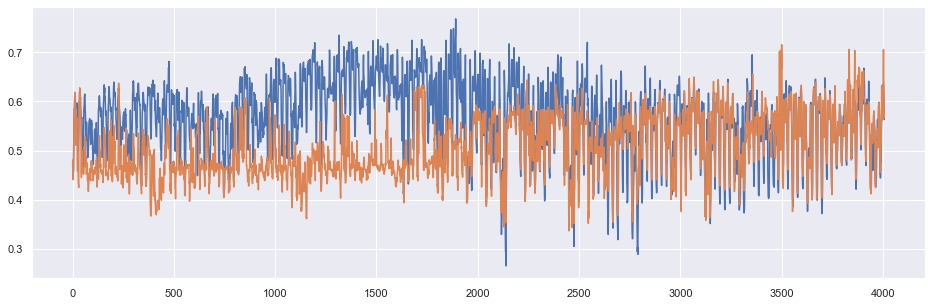

In [141]:
plt.figure(figsize=(16,5))
plt.plot(y_t)
plt.plot(xgb_model.predict(dtest)) #birinci testde pis netice gosterdiyine gore weatheri ayirdiq

# ----------- Section 1 ---------

In [71]:
%matplotlib inline
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, LinearRegression
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import roc_curve, plot_roc_curve, mean_absolute_error, mean_squared_error, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [83]:
def modelden_evvel(filepath):
    
    df = pd.read_csv(filepath,parse_dates=['time'],index_col='time')
 
    df.columns = df.columns.str.replace(' ','_').str.replace('-','_')

    df.index = pd.to_datetime(df.index, utc=True)    
    df['coal']=df['generation_fossil_brown_coal/lignite']+df['generation_fossil_hard_coal']
    
    df.drop(columns=['price_day_ahead',
                     'generation_marine',
                     'total_load_forecast',
                     'generation_geothermal',
                     'generation_fossil_peat',
                     'generation_wind_offshore',
                     'forecast_solar_day_ahead',
                     'generation_fossil_oil_shale',
                     'forecast_wind_onshore_day_ahead',
                     'forecast_wind_offshore_eday_ahead',
                     'generation_fossil_coal_derived_gas',
                     'generation_hydro_pumped_storage_aggregated'],inplace=True)
    
    df = df.drop(pd.Timestamp('2014-12-31 23:00:00+00:00')) 
    
    df = df.sort_index()
    
    condition_winter = (df.index.month>=1)&(df.index.month<=3)
    condtion_spring = (df.index.month>=4)&(df.index.month<=6)
    condition_summer = (df.index.month>=7)&(df.index.month<=9)
    condition_automn = (df.index.month>=10)@(df.index.month<=12)
    
    df['season'] = np.where(condition_winter,'qis',
                            np.where(condtion_spring,'yaz',
                                     np.where(condition_summer,'yay',
                                              np.where(condition_automn,'payiz',np.nan))))
    
    return df

df=modelden_evvel('Data/energy_dataset.csv')[['coal',
    'generation_fossil_oil',
    'generation_fossil_gas',
    'generation_hydro_water_reservoir',
    'generation_solar',
    'season',
   'generation_wind_onshore','price_actual']]

In [73]:
df.groupby('season').sum()

,coal,generation_fossil_oil,generation_fossil_gas,generation_hydro_water_reservoir,generation_hydro_run_of_river_and_poundage,generation_solar,generation_wind_onshore,price_actual
season,,,,,,,,
payiz,46740019.0,2606461.0,55426491.0,19188080.0,7317576.0,9035859.0,47737284.0,567381.44
qis,36971967.0,2607921.0,44429960.0,27419510.0,9724191.0,10548401.0,56779532.0,470440.62
yay,45717350.0,2696754.0,51895377.0,18717709.0,7023573.0,15721752.0,40600975.0,530610.17
yaz,35426277.0,2543319.0,45297786.0,25971653.0,10001418.0,14903149.0,46383989.0,461147.74


In [84]:
target='price_actual'

y,X=df[target]*1.73,df.drop(columns=target)

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.2,random_state=42)

In [85]:
X_train.shape

(28050, 7)

In [86]:
pipe_rs_xgb = make_pipeline(OrdinalEncoder(),
                            SimpleImputer(),
                            XGBRegressor(random_state=42,
                                         n_jobs=-1))

paramajama = {'simpleimputer__strategy':['mean'],
              'xgbregressor__max_depth':[25],
              'xgbregressor__learning_rate': [0.2],
              'xgbregressor__booster':['dart'],
              'xgbregressor__min_child_weight':[4],
              'xgbregressor__gamma':[0.5],
              'xgbregressor__max_delta_step':[0.0],
              'xgbregressor__subsample':[0.7]}

model_rs_xgbr = RandomizedSearchCV(pipe_rs_xgb,
                                   param_distributions = paramajama,
                                   n_iter=20,
                                   n_jobs=-1)

model_rs_xgbr.fit(X_train,y_train);

print('Training MAE:', mean_absolute_error(y_train,model_rs_xgbr.predict(X_train)))
print('-------------------------------------------------------------------')
print('Validation MAE:', mean_absolute_error(y_val,model_rs_xgbr.predict(X_val)))
print('-------------------------------------------------------------------')
print('R2 score:', model_rs_xgbr.score(X_val,y_val))

/Users/mehranzeynalli/opt/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/mehranzeynalli/opt/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/mehranzeynalli/opt/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/mehranzeynalli/opt/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be re

Training MAE: 0.27802962055335495
-------------------------------------------------------------------
Validation MAE: 8.593019174204997
-------------------------------------------------------------------
R2 score: 0.7633744564940702


In [116]:
from sklearn.metrics import r2_score
r2_score(y_val,model_rs_xgbr.predict(X_val))

0.8261458638080186

In [88]:
import joblib
joblib.dump(model_rs_xgbr,'final_xgb_pipeline.pkl')

['final_xgb_pipeline.pkl']

In [87]:
pred_data=pd.DataFrame({'komur':[4919.0],
             'neft':[295.0],
             'gaz':[330.0],
             'hidro su rezervi':[1583.0],
             'gunes':[84.0],
             'season':['yay'],
             'kulek':[2784.0]})
model_rs_xgbr.predict(pred_data)

array([90.53801], dtype=float32)

# Demand

In [8]:
demand_df=pd.read_csv('Data/energy_dataset.csv',parse_dates=['time'])

In [20]:
demand_df['year']=demand_df.apply(lambda x:x['time'].year,axis=1)
demand_df['month']=demand_df.apply(lambda x:x['time'].month,axis=1)
demand_df['day']=demand_df.apply(lambda x:x['time'].day,axis=1)

In [31]:
final_demand=demand_df[['year','month','day','total load actual']].groupby(['year','month','day']).sum().reset_index()

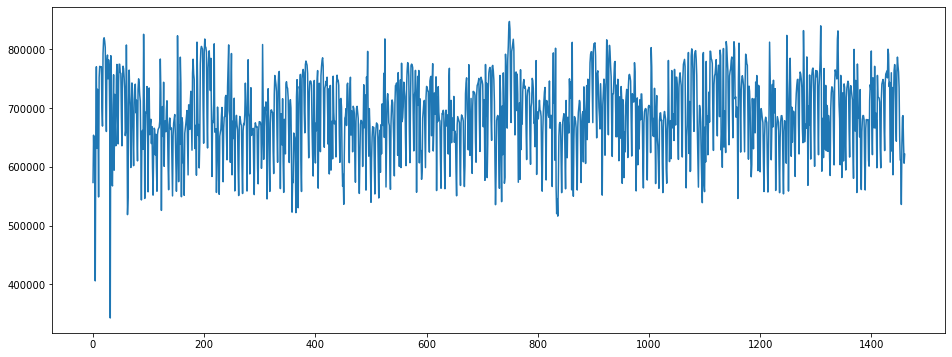

In [32]:
plt.figure(figsize=(16,6))
plt.plot(final_demand['total load actual'])

In [36]:
X=final_demand[['year','month','day']]
y=final_demand['total load actual']
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.2,random_state=42)

In [38]:
pipe_rs_xgb = make_pipeline(OrdinalEncoder(),
                            SimpleImputer(),
                            XGBRegressor(random_state=42,
                                         n_jobs=-1))

paramajama = {'simpleimputer__strategy':['mean'],
              'xgbregressor__max_depth':[25],
              'xgbregressor__learning_rate': [0.2],
              'xgbregressor__booster':['dart'],
              'xgbregressor__min_child_weight':[4],
              'xgbregressor__gamma':[0.5],
              'xgbregressor__max_delta_step':[0.0],
              'xgbregressor__subsample':[0.7]}

model_rs_xgbr = RandomizedSearchCV(pipe_rs_xgb,
                                   param_distributions = paramajama,
                                   n_iter=20,
                                   n_jobs=-1)

model_rs_xgbr.fit(X,y);

print('Training MAE:', mean_absolute_error(y_train,model_rs_xgbr.predict(X_train)))
print('-------------------------------------------------------------------')
print('Validation MAE:', mean_absolute_error(y_val,model_rs_xgbr.predict(X_val)))
print('-------------------------------------------------------------------')
print('R2 score:', model_rs_xgbr.score(X,y))

/Users/mehranzeynalli/opt/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/mehranzeynalli/opt/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/mehranzeynalli/opt/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Training MAE: 13165.643032962329
-------------------------------------------------------------------
Validation MAE: 12564.653690273037
-------------------------------------------------------------------
R2 score: 0.9370279724366323


In [69]:
pred_data=pd.DataFrame({'year':[2016],
                       'month':[6],
                       'day':[11]})
model_rs_xgbr.predict(pred_data)

array([598153.75], dtype=float32)

In [50]:
import joblib
joblib.dump(model_rs_xgbr,'demand.pkl')

['demand.pkl']

In [70]:
pred_data=pd.DataFrame({'year':[2016],
                       'month':[6],
                       'day':[11]})
joblib.load('demand.pkl').predict(pred_data)

array([598153.75], dtype=float32)